In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# Task 0: Introduction

The MNIST dataset is a benchmark dataset in machine learning and computer vision, consisting of 70,000 grayscale images of handwritten digits (0–9), each of size 28x28 pixels. The task is to classify each image into its corresponding digit, making it a multi-class classification problem. This challenge serves as an excellent introduction to deep learning, enabling the application of neural networks to solve real-world problems.

In this notebook, we will build a neural network using PyTorch to classify the MNIST digits. The solution involves loading and preprocessing the data, designing and training a deep learning model, evaluating its performance, and generating predictions for submission to Kaggle. This structured approach ensures reproducible results and facilitates understanding of fundamental deep learning concepts.

# Task 1: Importing Libraries

In [2]:
# Importing Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim

# Task 2: Loading the Dataset

In [3]:
# Load the MNIST Dataset
train_data_path = "/kaggle/input/digit-recognizer/train.csv"
test_data_path = "/kaggle/input/digit-recognizer/test.csv"

# Load Training Data
train_df = pd.read_csv(train_data_path)

# Task 3: Exploratory Data Analysis (EDA)

In [4]:
# Exploratory Data Analysis
# Display some basic statistics
print(train_df.describe())

              label   pixel0   pixel1   pixel2   pixel3   pixel4   pixel5  \
count  42000.000000  42000.0  42000.0  42000.0  42000.0  42000.0  42000.0   
mean       4.456643      0.0      0.0      0.0      0.0      0.0      0.0   
std        2.887730      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.000000      0.0      0.0      0.0      0.0      0.0      0.0   
25%        2.000000      0.0      0.0      0.0      0.0      0.0      0.0   
50%        4.000000      0.0      0.0      0.0      0.0      0.0      0.0   
75%        7.000000      0.0      0.0      0.0      0.0      0.0      0.0   
max        9.000000      0.0      0.0      0.0      0.0      0.0      0.0   

        pixel6   pixel7   pixel8  ...      pixel774      pixel775  \
count  42000.0  42000.0  42000.0  ...  42000.000000  42000.000000   
mean       0.0      0.0      0.0  ...      0.219286      0.117095   
std        0.0      0.0      0.0  ...      6.312890      4.633819   
min        0.0      0.0      0

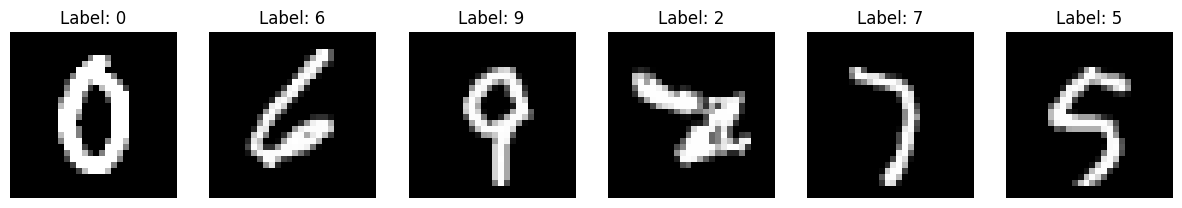

In [5]:
# Visualize a few samples from the dataset
def visualize_samples(dataframe, num_samples=6):
    """Visualizes random samples from the dataset."""
    samples = dataframe.sample(num_samples)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 4))
    for i, (idx, row) in enumerate(samples.iterrows()):
        label = row['label']
        image = row.drop('label').values.reshape(28, 28)
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Label: {label}")
    plt.show()

visualize_samples(train_df)

# Task 4: Data Preprocessing

In [6]:
# Data Preprocessing with a Custom Dataset Class
class MNISTDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame):
        self.labels = dataframe['label'].values
        self.images = dataframe.drop(columns=['label']).values.astype(np.float32) / 255.0

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx].reshape(28, 28)
        label = self.labels[idx]
        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Task 5: Splitting Data into Training and Validation Sets

In [7]:
# Train-Validation Split
train_set, val_set = train_test_split(train_df, test_size=0.2, random_state=42)
train_dataset = MNISTDataset(train_set)
val_dataset = MNISTDataset(val_set)

In [8]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Task 6: Building the Neural Network Model

In [9]:
# Define the Neural Network Model
input_layer = 784
hidden_layer1 = 128
hidden_layer2 = 64
output_layer = 10

model = nn.Sequential(
    nn.Linear(input_layer, hidden_layer1),
    nn.ReLU(),
    nn.Linear(hidden_layer1, hidden_layer2),
    nn.ReLU(),
    nn.Linear(hidden_layer2, output_layer)
)

# Loss Function and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Task 7: Training the Model

In [10]:
# Training the Model
def train_model(model, train_loader, val_loader, epochs=10):
    """Trains the neural network and evaluates it on validation data."""
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            predictions = model(images)
            loss = loss_function(predictions, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Validation Step
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                predictions = model(images)
                val_loss += loss_function(predictions, labels).item()
                correct += (predictions.argmax(1) == labels).sum().item()
        
        # Print Epoch Metrics
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {total_loss/len(train_loader):.4f}")
        print(f"Validation Loss: {val_loss/len(val_loader):.4f}")
        print(f"Validation Accuracy: {100 * correct / len(val_dataset):.2f}%")
        print("-" * 30)

In [11]:
train_model(model, train_loader, val_loader)

Epoch 1/10
Train Loss: 0.4294
Validation Loss: 0.2245
Validation Accuracy: 93.73%
------------------------------
Epoch 2/10
Train Loss: 0.1863
Validation Loss: 0.1626
Validation Accuracy: 95.23%
------------------------------
Epoch 3/10
Train Loss: 0.1338
Validation Loss: 0.1365
Validation Accuracy: 95.83%
------------------------------
Epoch 4/10
Train Loss: 0.0993
Validation Loss: 0.1475
Validation Accuracy: 95.54%
------------------------------
Epoch 5/10
Train Loss: 0.0795
Validation Loss: 0.1240
Validation Accuracy: 96.40%
------------------------------
Epoch 6/10
Train Loss: 0.0609
Validation Loss: 0.1046
Validation Accuracy: 96.87%
------------------------------
Epoch 7/10
Train Loss: 0.0490
Validation Loss: 0.1092
Validation Accuracy: 96.86%
------------------------------
Epoch 8/10
Train Loss: 0.0413
Validation Loss: 0.1027
Validation Accuracy: 97.01%
------------------------------
Epoch 9/10
Train Loss: 0.0323
Validation Loss: 0.1236
Validation Accuracy: 96.46%
--------------

# Task 8: Preprocessing Test Data

In [12]:
# Evaluate on Test Data
test_df = pd.read_csv(test_data_path)

In [13]:
# Prepare Test Dataset
class MNISTTestDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame):
        self.images = dataframe.values.astype(np.float32) / 255.0

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape(28, 28)
        return torch.tensor(image, dtype=torch.float32)

In [14]:
test_dataset = MNISTTestDataset(test_df)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Task 9: Making Predictions

In [15]:
# Make Predictions
def make_predictions(model, test_loader):
    """Predicts labels for the test dataset."""
    model.eval()
    predictions = []
    with torch.no_grad():
        for images in test_loader:
            images = images.view(images.size(0), -1)
            outputs = model(images)
            predicted_labels = outputs.argmax(1).tolist()
            predictions.extend(predicted_labels)
    return predictions

In [16]:
test_predictions = make_predictions(model, test_loader)

# Task 10: Creating the Submission File

In [17]:
# Save Results to Submission File
submission = pd.DataFrame({
    'ImageId': range(1, len(test_predictions) + 1),
    'Label': test_predictions
})
submission.to_csv("submission.csv", index=False)
print("Submission file created: submission.csv")

Submission file created: submission.csv
